<div style="text-align: right"><b>Autor</b>: Jose Miguel Zamora Batista | <b>Fecha</b>: 17 de abril de 2021 </div>

---

# Codelab I: Filtros de Kalman 1D

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Estimación de una constante escalar aleatoria
- voltaje = -0.37727
- Medida ruidosa (conversión analógico-digital). Ruido blanco 0.1 voltios

**Parámetros del problema**

In [2]:
# Create the values
voltage = -0.37727
max_noise = 0.1
iterations = 200

**Creación de la señal con ruido**

In [3]:
# Create the signal
signal = np.array([-0.37727] * iterations)

# Create the noisy signal
noise = np.random.normal(0, max_noise, signal.shape)
noisy_signal = signal + noise

**Función para mostrar los progresos del algoritmo**

In [4]:
def plot(y_noise, y_true, y_pred, niter, figsize=(10, 8)):
    x = range(niter)
    
    plt.figure(figsize=figsize)

    plt.plot(x, y_true, 'b-', label='y_true')
    plt.plot(x, y_noise, 'r.', label='y_noisy')
    plt.plot(x, y_pred, 'g-', label='y_pred')
    
    plt.xlabel('Iteraciones'); plt.ylabel('Signal')
    plt.legend(); plt.tight_layout(); plt.show()

**Clase ``Kalman1D``**

Su constructor contiene los parámtros que se necesitan para comenzar con estimaciones y las correcciones.

In [5]:
class Kalman1D:
    def __init__(self, A, B, u, H, R, Q, P, X):
        self.A, self.H = np.array(A), np.array(H)   
        self.B, self.u = B, u

        self.P, self.X = P, X
        self.R, self.Q = R, Q
    
    def predict(self, ):
        self.X = self.A * self.X + self.B * self.u
        self.P = self.A * self.P * self.A.T + self.Q
    
    def correct(self, Z):
        K = (self.P * self.H.T) / (self.H * self.P * self.H.T + self.R)
        self.P = self.P - K * self.H * self.P
        self.X = self.X + K * (Z - self.H * self.X)
        
    def execute(self, values):
        kalman_signal = []
        for z_t in values:
            self.predict()
            self.correct(z_t)
            kalman_signal.append(self.X)
        return kalman_signal

## Mostrar gráficas de evolución de la ejecución del algoritmo con distintos valores de R (R=0.01, R=1, R=0.0001)
 
 - Medida ruidosa
 - Estimado a posteriori
 - Medida real del proceso
 - Error estimado a posteriori



### R = 0.01

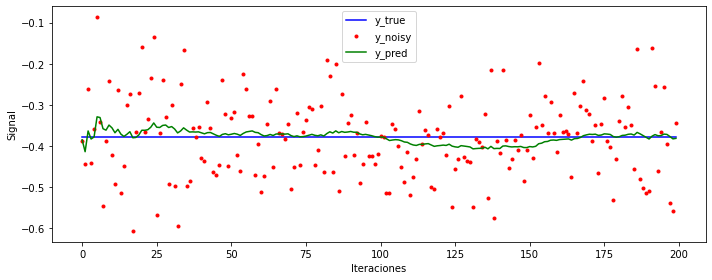

In [6]:
kalman_filter = Kalman1D(A=1, B=1, u=0, H=1, R=0.01, Q=0.00001, P=1, X=0)
kalman_signal = kalman_filter.execute(noisy_signal)
plot(noisy_signal, signal, kalman_signal, niter=iterations, figsize=(10, 4))

### R = 1

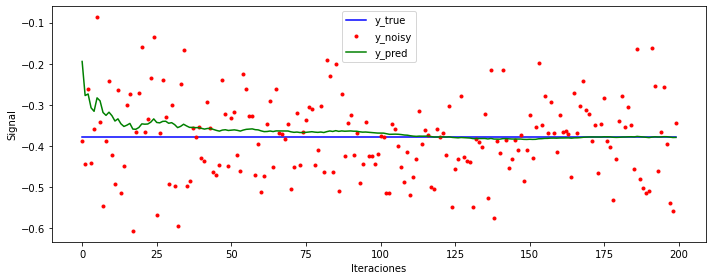

In [7]:
kalman_filter = Kalman1D(A=1, B=1, u=0, H=1, R=1, Q=0.00001, P=1, X=0)
kalman_signal = kalman_filter.execute(noisy_signal)
plot(noisy_signal, signal, kalman_signal, niter=iterations, figsize=(10, 4))

### R = 0.0001

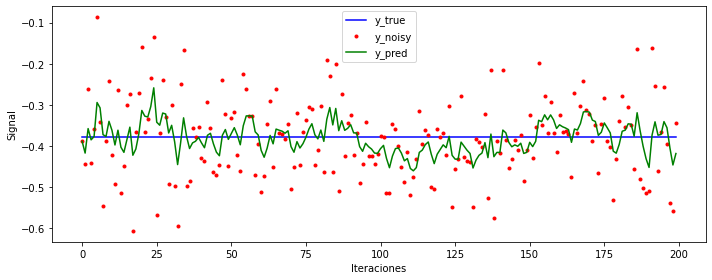

In [8]:
kalman_filter = Kalman1D(A=1, B=1, u=0, H=1, R=0.0001, Q=0.00001, P=1, X=0)
kalman_signal = kalman_filter.execute(noisy_signal)
plot(noisy_signal, signal, kalman_signal, niter=iterations, figsize=(10, 4))


___

# Codelab II: Filtros de Kalman Matriciales

In [9]:
import cv2 as cv
from IPython.display import Image, display

**Funciones auxiliares**

In [10]:
def center(x, y, w, h):
    return x + w // 2, y + h // 2

def plot_centers(frame, centers, color, sth):
    for i in range(len(centers)):
        if i != 0: frame = cv.line(frame, centers[i], centers[i-1], color, sth)
    return frame

def plot_v(frame, vx, vy, origin, color=(0, 255, 255)):
    
    font, font_scale, thickness = cv.FONT_HERSHEY_SIMPLEX, 1, 2    
    text = f"Vx: {vx}\nVy: {vy}"
    
    y, dy = origin[1], 50
    for i, line in enumerate(text.split('\n')):
        frame = cv.putText(frame, line, (origin[0], y ), font, font_scale, 
                           color, thickness, cv.LINE_AA, False)
        y = y + dy
        
    return frame

**Configuración de las localizaciones de los contenidos**

Cambiar el valor de la variable `player` para cambiar el vídeo

In [11]:
player = 3  # 1, 2 or 3
player_filepath = f'sequences/seq_kalman_filter/data/player_data_{player}.txt'
player_data = np.loadtxt(player_filepath, delimiter=',', dtype=np.int32)

sequence_path = 'sequences/seq_kalman_filter/images/%04d.jpg'

**Vídeo Original**

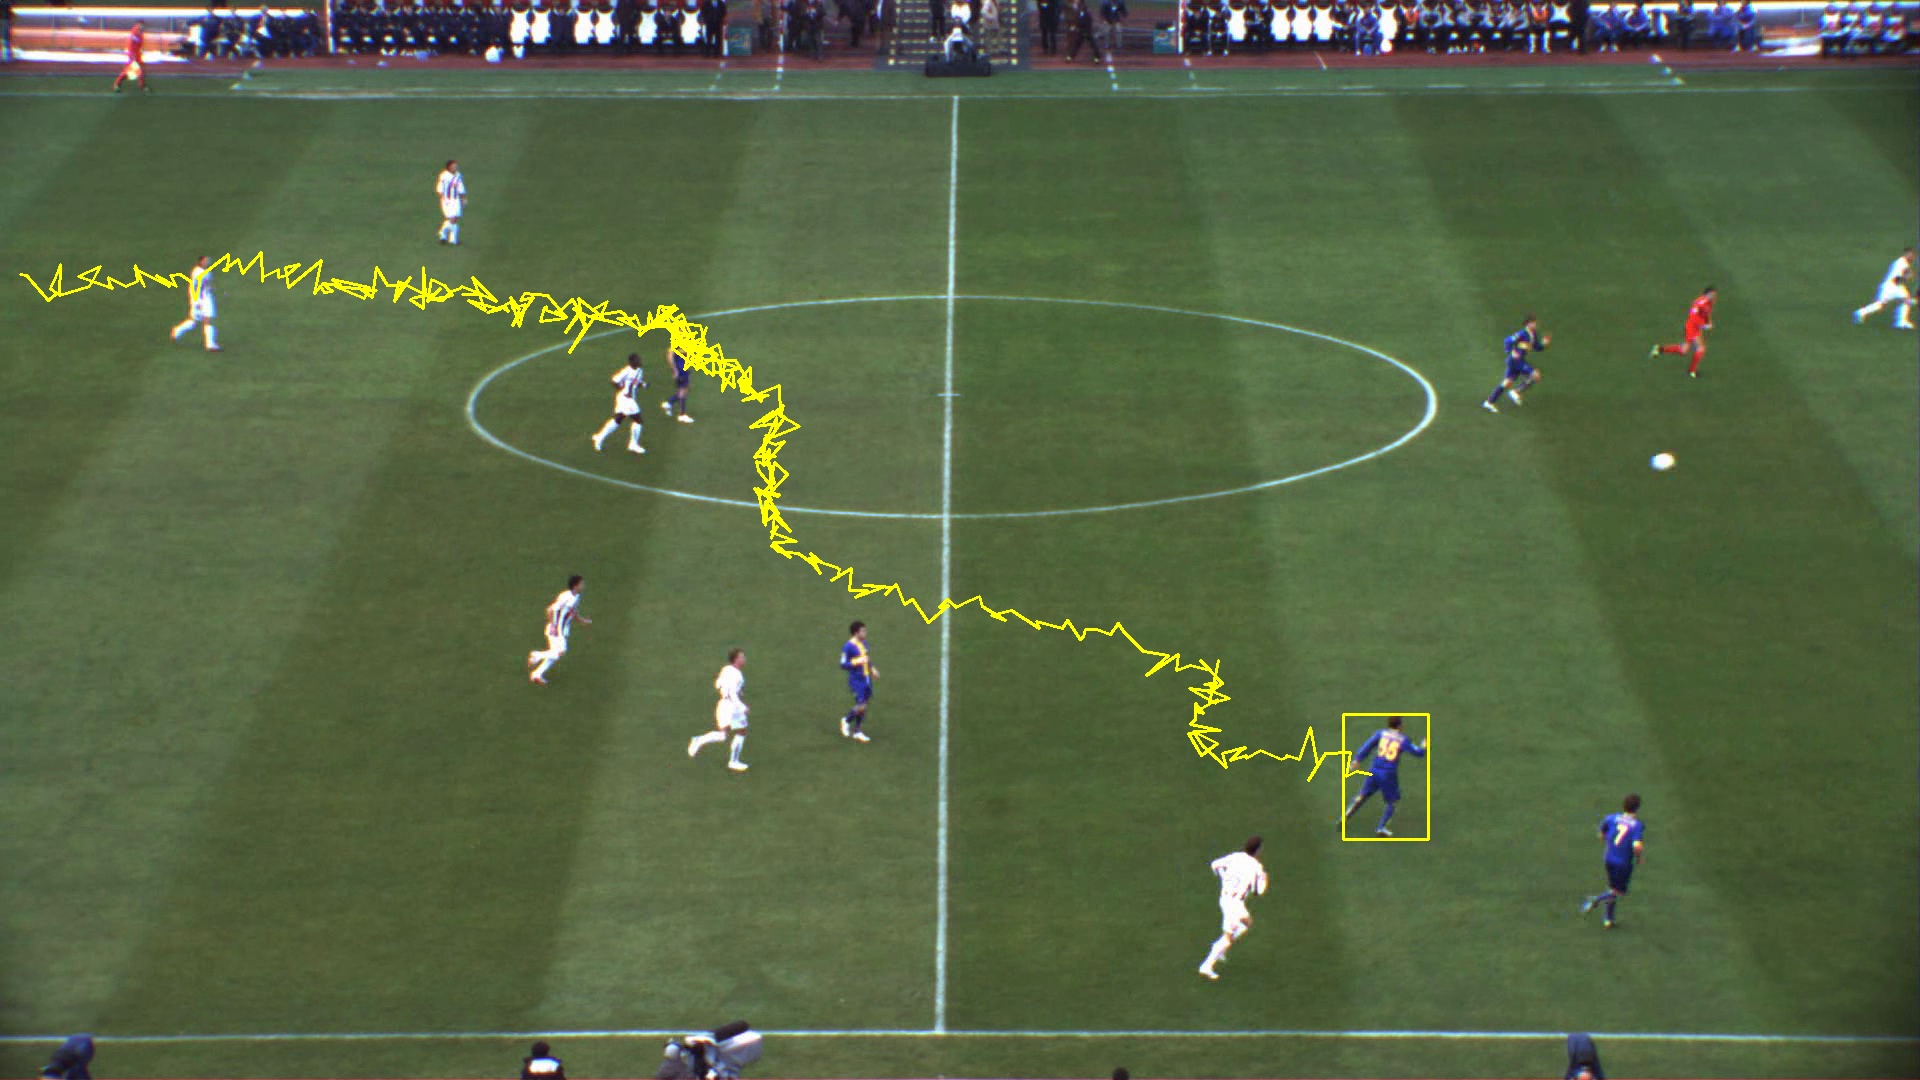

In [12]:
vc = cv.VideoCapture(sequence_path)
fs = int(vc.get(cv.CAP_PROP_FRAME_COUNT))

display_handle = display(None, display_id=True)
centers = []
color = (0, 255, 255)

for i in range(fs):
    _, frame = vc.read()
    x, y, w, h = player_data[i]
    
    frame = plot_centers(frame, centers, color, 2)
    frame = cv.rectangle(frame, (x, y), (x + w, y + h), color, 2)
    
    display_handle.update(Image(data=cv.imencode('.jpeg', frame)[1]))
    centers.append(center(x, y, w, h))
    
vc.release()

## Implementación del filtro de Kalman matricial

In [13]:
class Kalman:
    
    def __init__(self, A, H, X_ini, P_ini, R, Q):
        self.A = A
        self.H = H
        self.X = X_ini
        self.P = P_ini
        self.R = R
        self.Q = Q
    
    def predict(self, ):
        self.X = self.A @ self.X
        self.P = self.A @ (self.P @ self.A.T) + self.Q
    
    def correct(self, Z):
        H_R_HT = self.H @ (self.P @ self.H.T) + self.R
        K = self.P @ (self.H.T @ np.linalg.inv(H_R_HT))    
    
        self.P = self.P - K @ (self.H @ self.P)
        self.X = self.X + K @ (Z - self.H @ self.X)

**Vídeo con Bboxes filtradas**

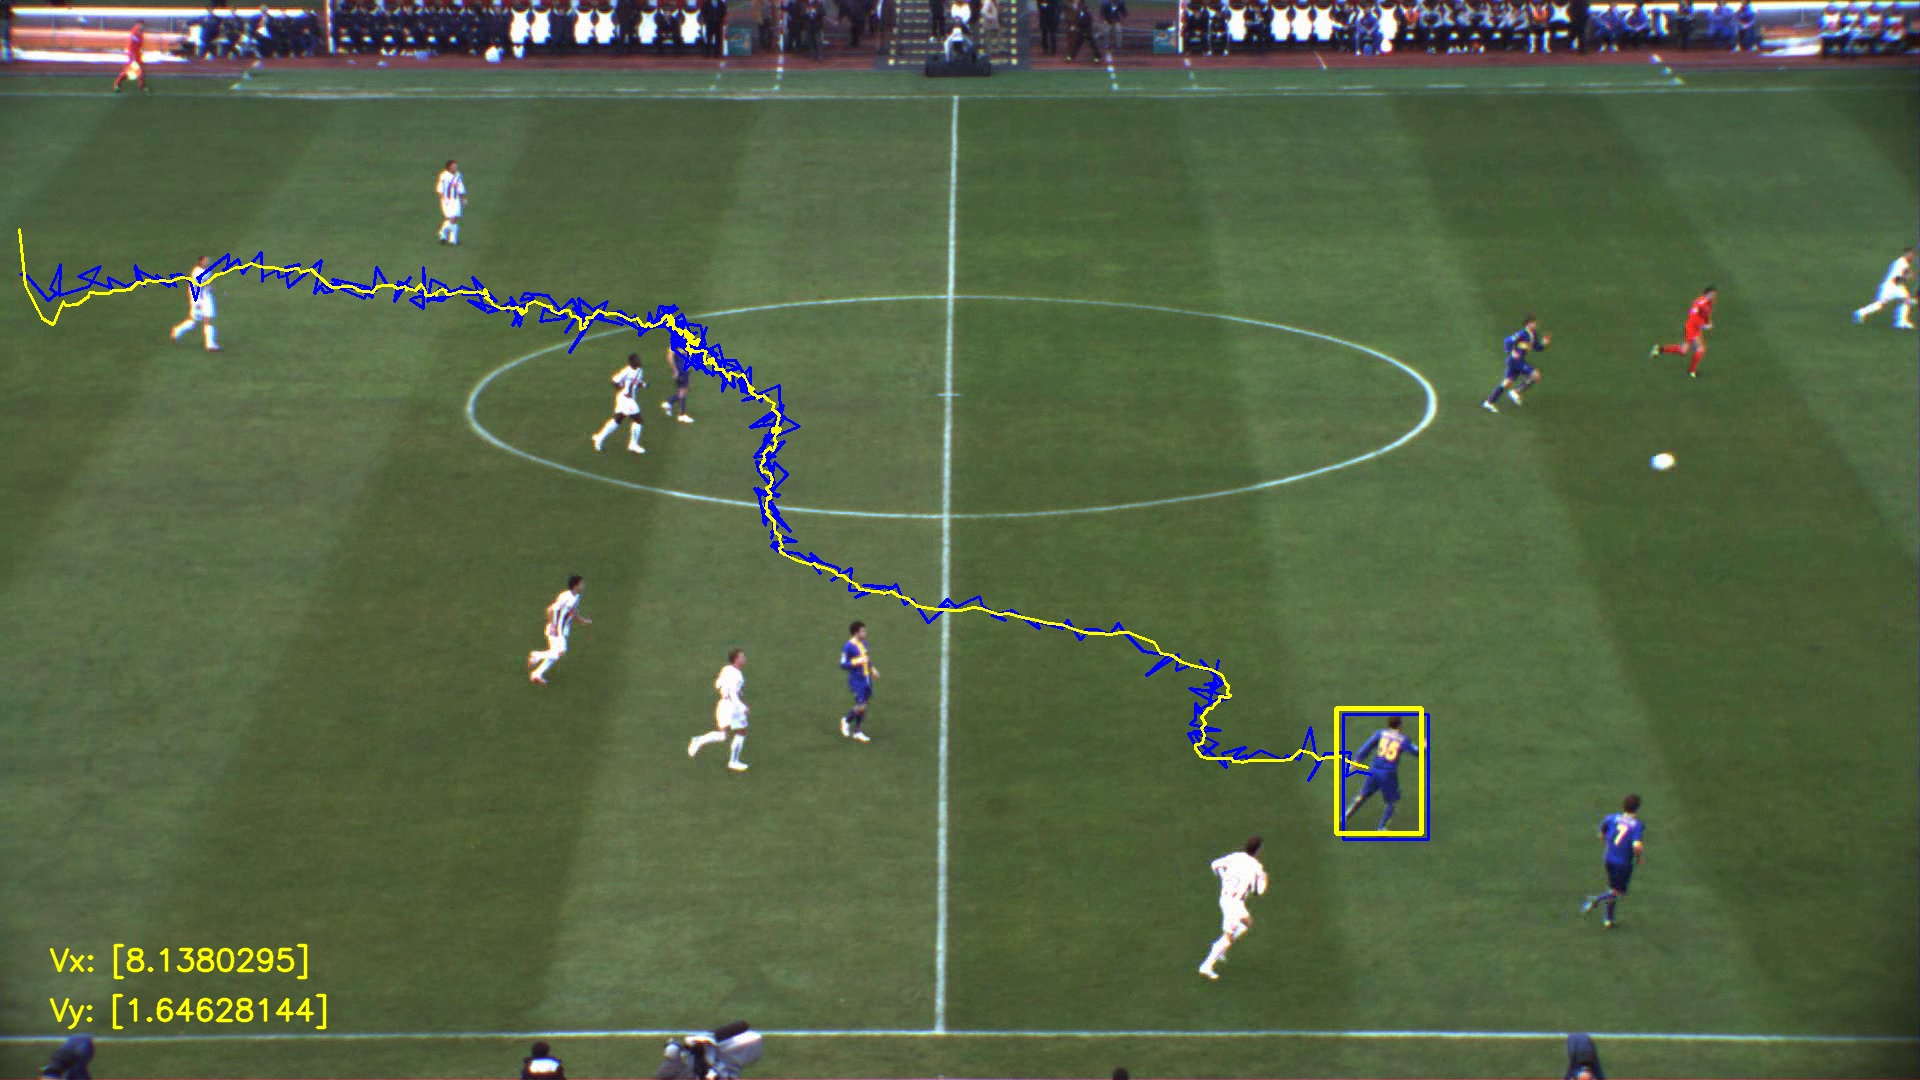

In [14]:
vc = cv.VideoCapture(sequence_path)
display_handle = display(None, display_id=True)

# Declare the Kalman filter params
A = np.eye(4) + np.diag((1, 1), k=2)
H = np.eye(2, 4)
R = np.eye(2) * 0.5
Q = np.eye(4) * 10e-4
X_ini = np.zeros((4, 1))
P_ini = np.eye(4)

# Crate the Kalman object with params
kalman = Kalman(A, H, X_ini, P_ini, R, Q)

# Create lists to plot the center (x, y) coords
centers_or, centers_km = [], []
color_or, color_km = (255, 0, 0), (0, 255, 255)

for i in range(fs):
    # Get current measurenment
    x0, y0, w, h = player_data[i]
    
    # Prediction
    kalman.predict()
    
    # Update Z with measurement
    Z = [[x0], [y0]]
    
    # Correction
    kalman.correct(np.array(Z))
    
    # Get filtered measurement
    x, y, vx, vy = kalman.X
    
    # Read the frame
    _, frame = vc.read()
    
    # Draw the vx, vy texts
    frame = plot_v(frame, vx, vy, (50, 970))

    # Draw the centers 
    frame = plot_centers(frame, centers_or, color_or, 2)
    frame = plot_centers(frame, centers_km, color_km, 2)
    
    # Draw bounding boxes
    frame = cv.rectangle(frame, (x0, y0), (x0 + w, y0 + h), color_or, 2)
    frame = cv.rectangle(frame, (x, y), (x + w, y + h), color_km, 3)
    
    # Update frame
    display_handle.update(Image(data=cv.imencode('.jpeg', frame)[1]))
    
    # Append new centers
    centers_or.append(center(x0, y0, w, h))
    centers_km.append(center(x, y, w, h))
    
vc.release()

---

## Pregunta Teórica:

Explica y **razona** qué valores **R** y **Q** han sido seleccionados para cada `.csv` de detecciones.

**Respuesta**

- **Q** es la covarianza del ruido del proceso.
- **R** es la covarianza del ruido de las predicciones. 

Los valores que se han elegido son los que mejor modelan el estado y la medida, y son valores que se imponen a priori.

Si **R** es muy parecido al ruido del sistema se obtendrán las mejores predicciones. Sin embargo, cuanto más grande es se tardará más tiempo en obtener buenas predicciones porque se esta modelizando más ruido del que realmente hay. Por otra parte, si es muy pequeño no se tiene en cuenta la medida.

Si **Q** es muy grande, se distorsiona mucho la predicción (es decir estamos incluyendo en la predicción más ruido del que realmente hay), pero si es muy pequeña se asume que la predicción a priori depende mucho de la predicción a posteriori del estado anterior, por lo que las predicciones cada vez son peores y no son capaces de ajustar al problema.

La siguiente tabla muestra los valores que se han elegido para cada `.csv`:

| csv | R | Q |
| --- | --- | --- |
| player_data_1.txt | 0.1 | 10e-4 |
| player_data_2.txt | 0.1 | 10e-4 |
| player_data_3.txt | 0.5 | 10e-4 |